In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (roc_auc_score, average_precision_score, accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score, confusion_matrix, brier_score_loss, log_loss)

In [ ]:
from scipy.stats import wilcoxon
from pandas.api.types import is_numeric_dtype
from sklearn.impute import SimpleImputer
from scipy.stats import mannwhitneyu, brunnermunzel
from scipy.optimize import curve_fit

## AUC

In [ ]:
df = pd.read_csv('df.csv')

In [ ]:
df = pd.read_csv('df.csv')
df.rename(columns=lambda s: s.strip() if isinstance(s, str) else s, inplace=True)
leak_like = {'id','index','patient','subject','uid','timestamp','time','file','name'}
drop_cols = [c for c in df.columns if c.lower() in leak_like]
df = df.drop(columns=drop_cols, errors='ignore')

target_col = 'disease'
assert target_col in df.columns, "В df нет столбца 'disease'"
y = df[target_col].astype(int)

X = df.drop(columns=[target_col]).select_dtypes(include=[np.number])
rs = 42
perm = np.random.RandomState(rs).permutation(len(X))
X = X.iloc[perm].reset_index(drop=True)
y = y.iloc[perm].reset_index(drop=True)
k_grid = [k for k in (5, 10, 15) if k <= max(1, X.shape[1])] or [min(3, X.shape[1])]

pre_steps = [ ('impute', SimpleImputer(strategy='median', add_indicator=True)), ('var0',   VarianceThreshold(threshold=0.0)),
              ('scale',  RobustScaler(with_centering=False)), ('kbest',  SelectKBest(score_func=f_classif))]

models = {'logreg_l1': LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', max_iter=5000, random_state=0),
          'linsvm': LinearSVC(C=1.0, class_weight='balanced', random_state=0),
          'lda_shr': LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto'),
          'gnb': GaussianNB()}

param_grids = {'logreg_l1': {'kbest__k': k_grid, 'model__C': [0.05, 0.1, 0.2, 0.5, 1, 2]},
               'linsvm': {'kbest__k': k_grid, 'model__C': [0.05, 0.1, 0.2, 0.5, 1, 2]},
               'lda_shr': {'kbest__k': k_grid}, 'gnb': {'kbest__k': k_grid}}

cv_outer = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=0)
cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [ ]:
def fit_eval(name, base_estimator):
    pipe = Pipeline(pre_steps + [('model', base_estimator)])
    gs = GridSearchCV(estimator=pipe, param_grid=param_grids[name],
                      cv=cv_inner, scoring='roc_auc', n_jobs=-1)

    scores = []
    for tr, te in cv_outer.split(X, y):
        gs.fit(X.iloc[tr], y.iloc[tr])
        best = gs.best_estimator_
        last = best.named_steps['model']

        if hasattr(last, 'decision_function'):
            s = best.decision_function(X.iloc[te])
        elif hasattr(last, 'predict_proba'):
            s = best.predict_proba(X.iloc[te])[:, 1]
        else:
            s = best.predict(X.iloc[te])

        auc = roc_auc_score(y.iloc[te], s)
        scores.append(auc)

    scores = np.asarray(scores, dtype=float)
    print(f'{name}: ROC-AUC {scores.mean():.3f} ± {scores.std():.3f}')

for name, clf in models.items():
    fit_eval(name, clf)


logreg_l1: ROC-AUC 0.461 ± 0.260
linsvm: ROC-AUC 0.477 ± 0.247
lda_shr: ROC-AUC 0.437 ± 0.243
gnb: ROC-AUC 0.330 ± 0.238


In [ ]:
df = pd.read_csv('df.csv')
df.rename(columns=lambda s: s.strip() if isinstance(s, str) else s, inplace=True)
target_candidates = {"disease","diagnosis","diag","label","target","class","y","pd_et","pd-et","pd/et"}
lower = {c.lower(): c for c in df.columns}
target_col = next((lower[k] for k in target_candidates if k in lower), None)

if target_col is None:
    for c in df.columns:
        try:
            vals = pd.to_numeric(df[c], errors='coerce').dropna().unique().astype(float)
        except Exception:
            continue
        s = set(vals.tolist())
        if s.issubset({0.0, 1.0}) and len(s) == 2:
            target_col = c
            break
assert target_col is not None, "Не найден столбец меток (например, 'disease')"


lat_pat = re.compile(r'^latency_(\d+)_([LR])$', re.IGNORECASE)
lat_cols = []
for c in df.columns:
    m = lat_pat.match(str(c))
    if m:
        imp = int(m.group(1))
        side = m.group(2).upper()
        lat_cols.append((c, imp, side))
assert len(lat_cols) > 0, "Не найдено колонок вида latency_{i}_{L/R}"

by_eye = {'L': {}, 'R': {}}
for cname, imp, side in lat_cols:
    by_eye[side][imp] = cname

imps_L = sorted(by_eye['L'].keys())
imps_R = sorted(by_eye['R'].keys())

# FDR
def fdr_bh(pvals, alpha=0.05):
    p = np.asarray(pvals, dtype=float)
    n = p.size
    order = np.argsort(p)
    ranked = p[order]
    adj = np.empty_like(ranked)
    prev = 1.0
    for i in range(n-1, -1, -1):
        val = ranked[i] * n / (i+1)
        if not np.isfinite(val):
            val = 1.0
        adj[i] = min(prev, val)
        prev = adj[i]
    out = np.empty_like(adj)
    out[order] = adj
    return out

In [ ]:
def run_wilcoxon_for_group(df_sub, eye, impulses, min_pairs=5):
    rows = []
    for i, j in zip(impulses[:-1], impulses[1:]):
        c1, c2 = by_eye[eye][i], by_eye[eye][j]
        x = pd.to_numeric(df_sub[c1], errors='coerce')
        y = pd.to_numeric(df_sub[c2], errors='coerce')
        mask = x.notna() & y.notna()
        x, y = x[mask].to_numpy(dtype=float), y[mask].to_numpy(dtype=float)
        n = len(x)
        if n >= min_pairs:
            r2 = wilcoxon(x, y, alternative='two-sided', zero_method='wilcox', method='auto')
            r1 = wilcoxon(x, y, alternative='greater',   zero_method='wilcox', method='auto')
            rows.append(dict(
                eye=eye, type='adjacent', comparison=f'{i}→{j}', n_pairs=n,
                median_diff=float(np.nanmedian(x - y)),
                p_two_sided=float(r2.pvalue), p_decrease=float(r1.pvalue)
            ))
        else:
            rows.append(dict(
                eye=eye, type='adjacent', comparison=f'{i}→{j}', n_pairs=n,
                median_diff=np.nan, p_two_sided=np.nan, p_decrease=np.nan
            ))

    if len(impulses) >= 2:
        i, j = impulses[0], impulses[-1]
        c1, c2 = by_eye[eye][i], by_eye[eye][j]
        x = pd.to_numeric(df_sub[c1], errors='coerce')
        y = pd.to_numeric(df_sub[c2], errors='coerce')
        mask = x.notna() & y.notna()
        x, y = x[mask].to_numpy(dtype=float), y[mask].to_numpy(dtype=float)
        n = len(x)
        if n >= min_pairs:
            r2 = wilcoxon(x, y, alternative='two-sided', zero_method='wilcox', method='auto')
            r1 = wilcoxon(x, y, alternative='greater',   zero_method='wilcox', method='auto')
            rows.append(dict(
                eye=eye, type='first_vs_last', comparison=f'{i}→{j}', n_pairs=n,
                median_diff=float(np.nanmedian(x - y)),
                p_two_sided=float(r2.pvalue), p_decrease=float(r1.pvalue)
            ))
        else:
            rows.append(dict(
                eye=eye, type='first_vs_last', comparison=f'{i}→{j}', n_pairs=n,
                median_diff=np.nan, p_two_sided=np.nan, p_decrease=np.nan
            ))
    return rows

results = []
results += run_wilcoxon_for_group(df, 'L', imps_L)
results += run_wilcoxon_for_group(df, 'R', imps_R)

for val, name in [(0, 'PD'), (1, 'ET')]:
    sub = df[df[target_col] == val]
    rows = run_wilcoxon_for_group(sub, 'L', imps_L) + run_wilcoxon_for_group(sub, 'R', imps_R)
    for r in rows:
        r['group'] = name
    results += rows

for r in results:
    r.setdefault('group', 'ALL')

res_df = pd.DataFrame(results, columns=[
    'group','eye','type','comparison','n_pairs','median_diff','p_two_sided','p_decrease'
])


adj_two, adj_dec = [], []
for (g,e,t), blk in res_df.groupby(['group','eye','type'], sort=False):
    p2 = blk['p_two_sided'].to_numpy()
    p1 = blk['p_decrease'].to_numpy()
    m2 = ~np.isnan(p2); m1 = ~np.isnan(p1)
    padj2 = fdr_bh(p2[m2]) if m2.any() else np.array([])
    padj1 = fdr_bh(p1[m1]) if m1.any() else np.array([])
    i2 = iter(padj2); i1 = iter(padj1)
    for i in range(len(blk)):
        adj_two.append(next(i2) if m2[i] else np.nan)
        adj_dec.append(next(i1) if m1[i] else np.nan)

res_df['p_two_sided_fdr'] = adj_two
res_df['p_decrease_fdr'] = adj_dec

order_type = {'first_vs_last': 0, 'adjacent': 1}
res_df['__ord'] = res_df['type'].map(order_type).fillna(2)
res_df.sort_values(['group','eye','__ord','comparison'], inplace=True)
res_df.drop(columns='__ord', inplace=True)

out_csv = 'wilcoxon_latency_tests.csv'
res_df.to_csv(out_csv, index=False)
sig = res_df[(res_df['p_decrease_fdr'].notna()) & (res_df['p_decrease_fdr'] <= 0.05)]
#print("Значимые уменьшения (FDR<=0.05) по тесту 'decrease' (x>y):")
#print(sig[['group','eye','type','comparison','n_pairs','median_diff','p_decrease','p_decrease_fdr']].to_string(index=False))



In [ ]:
res_df[res_df['type']=="first_vs_last"]

,group,eye,type,comparison,n_pairs,median_diff,p_two_sided,p_decrease,p_two_sided_fdr,p_decrease_fdr
7,ALL,L,first_vs_last,0→7,21,62.0,0.022798,0.011399,0.022798,0.011399
15,ALL,R,first_vs_last,0→7,12,82.0,0.003418,0.001709,0.003418,0.001709
39,ET,L,first_vs_last,0→7,8,57.0,0.382812,0.191406,0.382812,0.191406
47,ET,R,first_vs_last,0→7,4,NaN,NaN,NaN,NaN,NaN
23,PD,L,first_vs_last,0→7,13,68.0,0.032715,0.016357,0.032715,0.016357
31,PD,R,first_vs_last,0→7,8,83.0,0.023438,0.011719,0.023438,0.011719


## Correlation matrix

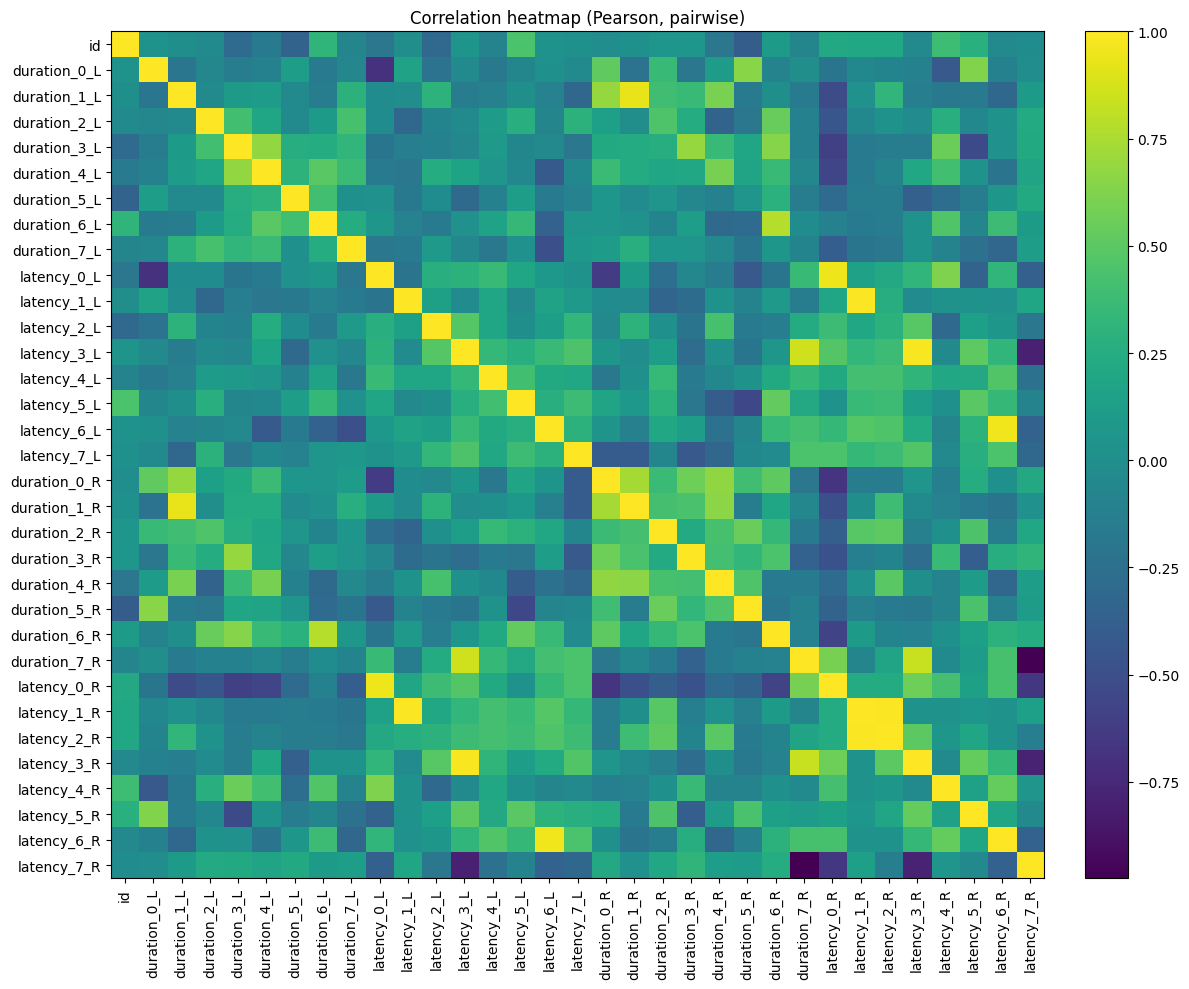

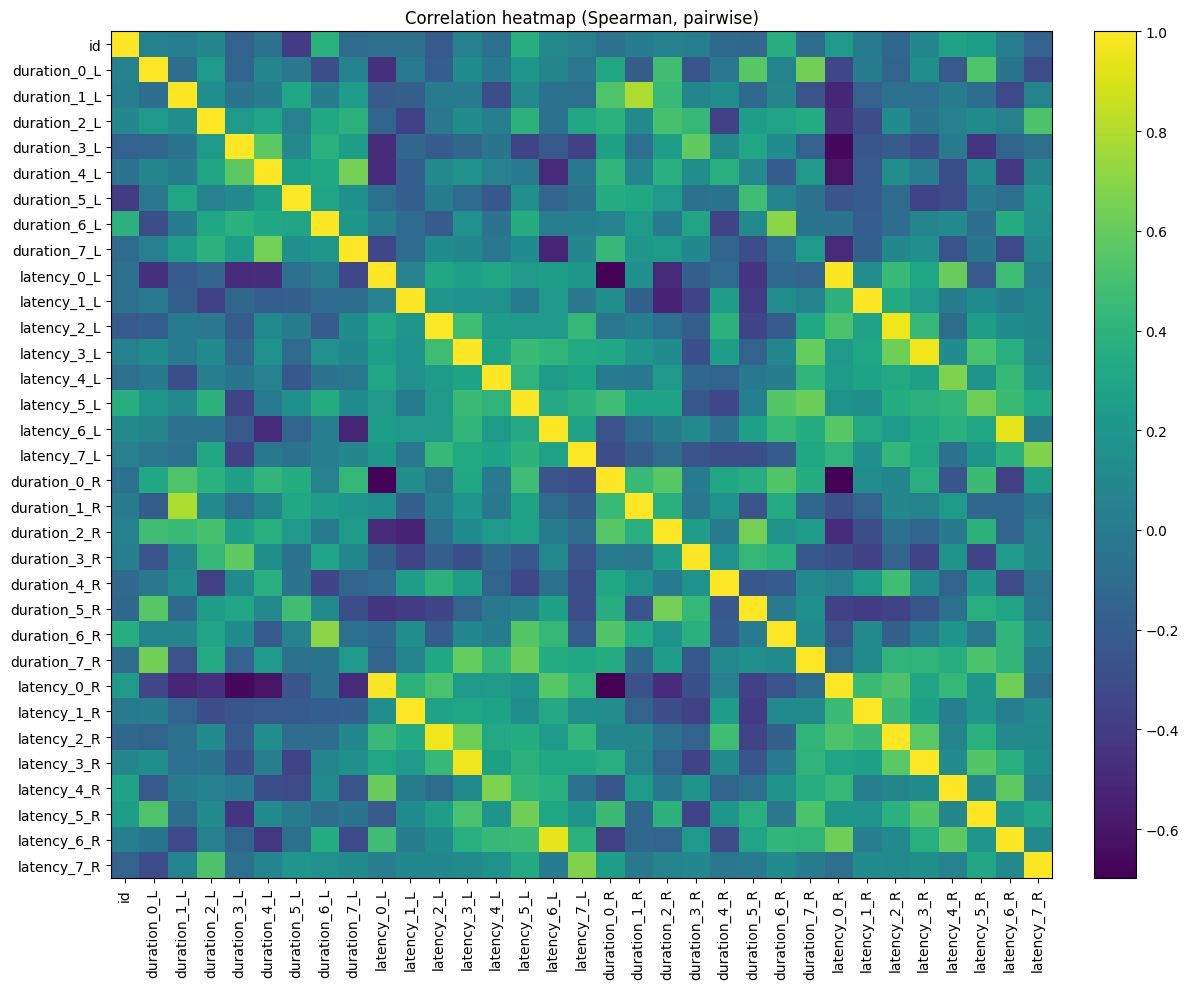

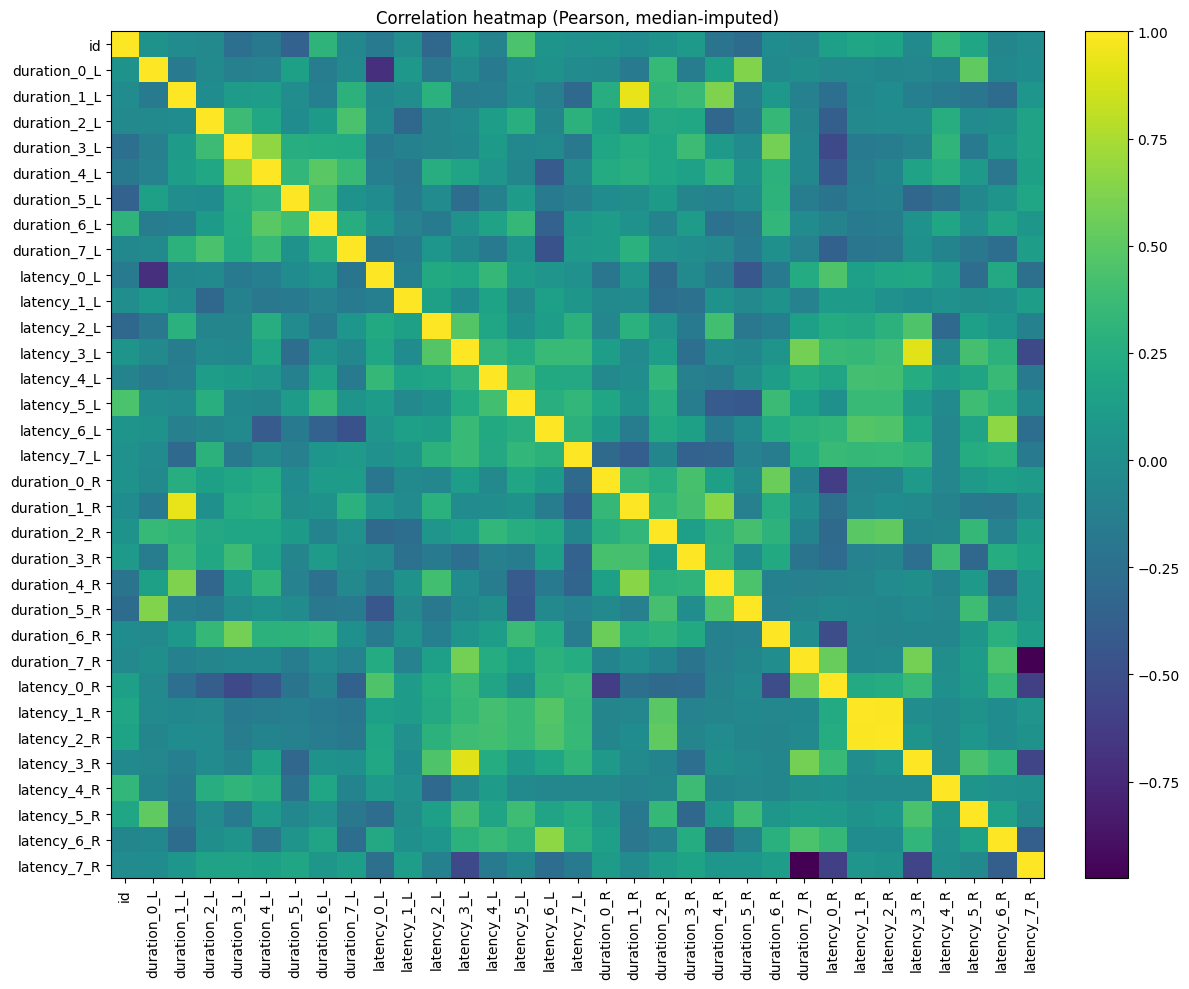

In [ ]:
df = pd.read_csv('df.csv' )

target_names = {'disease','diagnosis','diag','label','target','class','y','pd_et','pd-et','pd/et'}
lower_map = {c.lower(): c for c in df.columns}
target_col = next((lower_map[n] for n in target_names if n in lower_map), None)

X = df.select_dtypes(include=[np.number]).copy()
if target_col in X.columns:
    X = X.drop(columns=[target_col])

corr_pearson  = X.corr(method='pearson',  min_periods=2)
corr_spearman = X.corr(method='spearman', min_periods=2)

#corr_pearson.to_csv('corr_pearson_pairwise.csv')
#corr_spearman.to_csv('corr_spearman_pairwise.csv')

plt.figure(figsize=(12, 10))
img = plt.imshow(corr_pearson.values, aspect='auto', interpolation='nearest')
plt.title('Correlation heatmap (Pearson, pairwise)')
plt.xticks(ticks=np.arange(corr_pearson.shape[1]), labels=corr_pearson.columns, rotation=90)
plt.yticks(ticks=np.arange(corr_pearson.shape[0]), labels=corr_pearson.index)
plt.colorbar(img, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))
img2 = plt.imshow(corr_spearman.values, aspect='auto', interpolation='nearest')
plt.title('Correlation heatmap (Spearman, pairwise)')
plt.xticks(ticks=np.arange(corr_spearman.shape[1]), labels=corr_spearman.columns, rotation=90)
plt.yticks(ticks=np.arange(corr_spearman.shape[0]), labels=corr_spearman.index)
plt.colorbar(img2, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


imp = SimpleImputer(strategy='median')
X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns, index=X.index)

corr_pearson_imp  = X_imp.corr(method='pearson')
corr_spearman_imp = X_imp.corr(method='spearman')

corr_pearson_imp.to_csv('corr_pearson_imputed.csv')
corr_spearman_imp.to_csv('corr_spearman_imputed.csv')

plt.figure(figsize=(12, 10))
img3 = plt.imshow(corr_pearson_imp.values, aspect='auto', interpolation='nearest')
plt.title('Correlation heatmap (Pearson, median-imputed)')
plt.xticks(ticks=np.arange(corr_pearson_imp.shape[1]), labels=corr_pearson_imp.columns, rotation=90)
plt.yticks(ticks=np.arange(corr_pearson_imp.shape[0]), labels=corr_pearson_imp.index)
plt.colorbar(img3, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


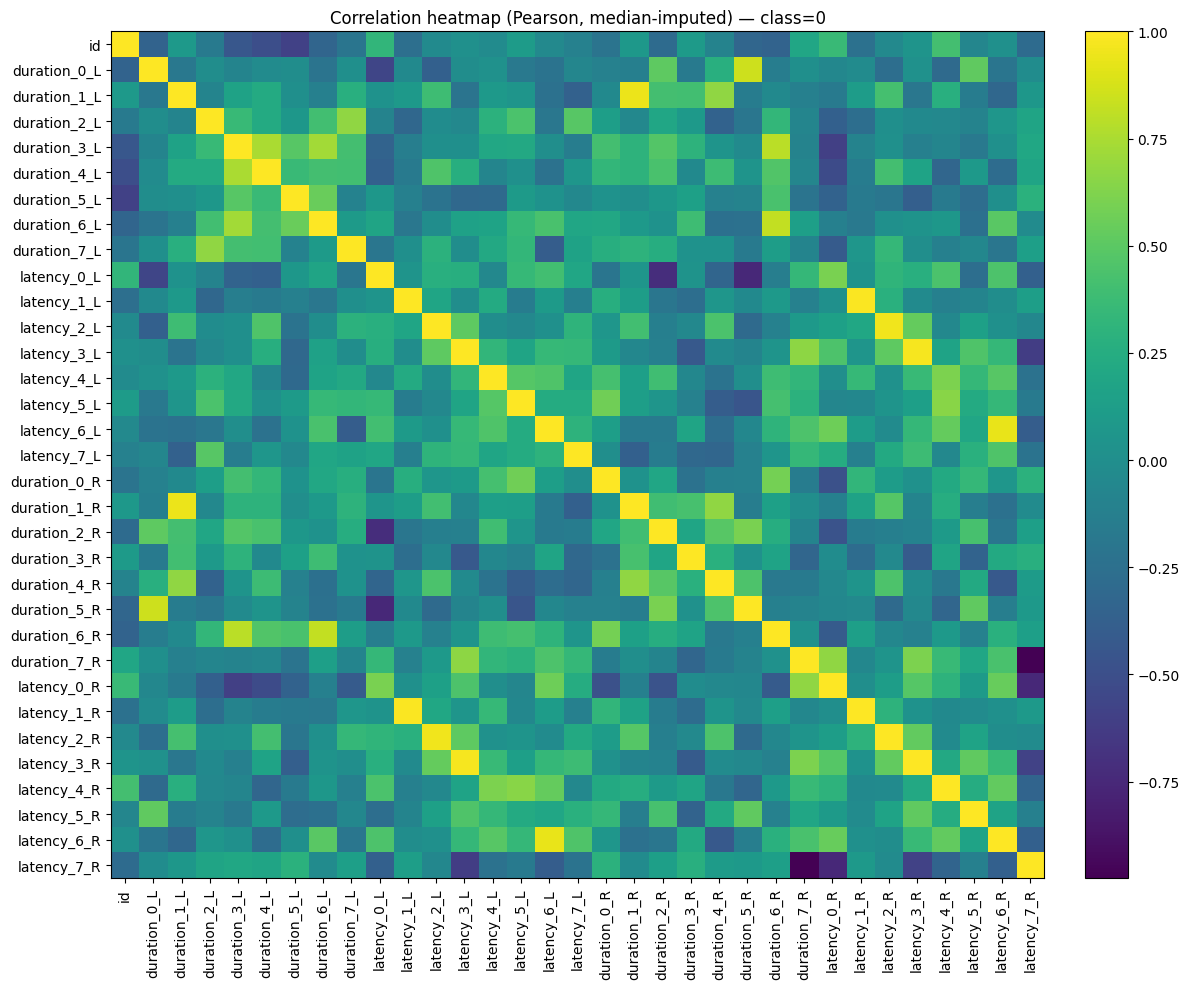

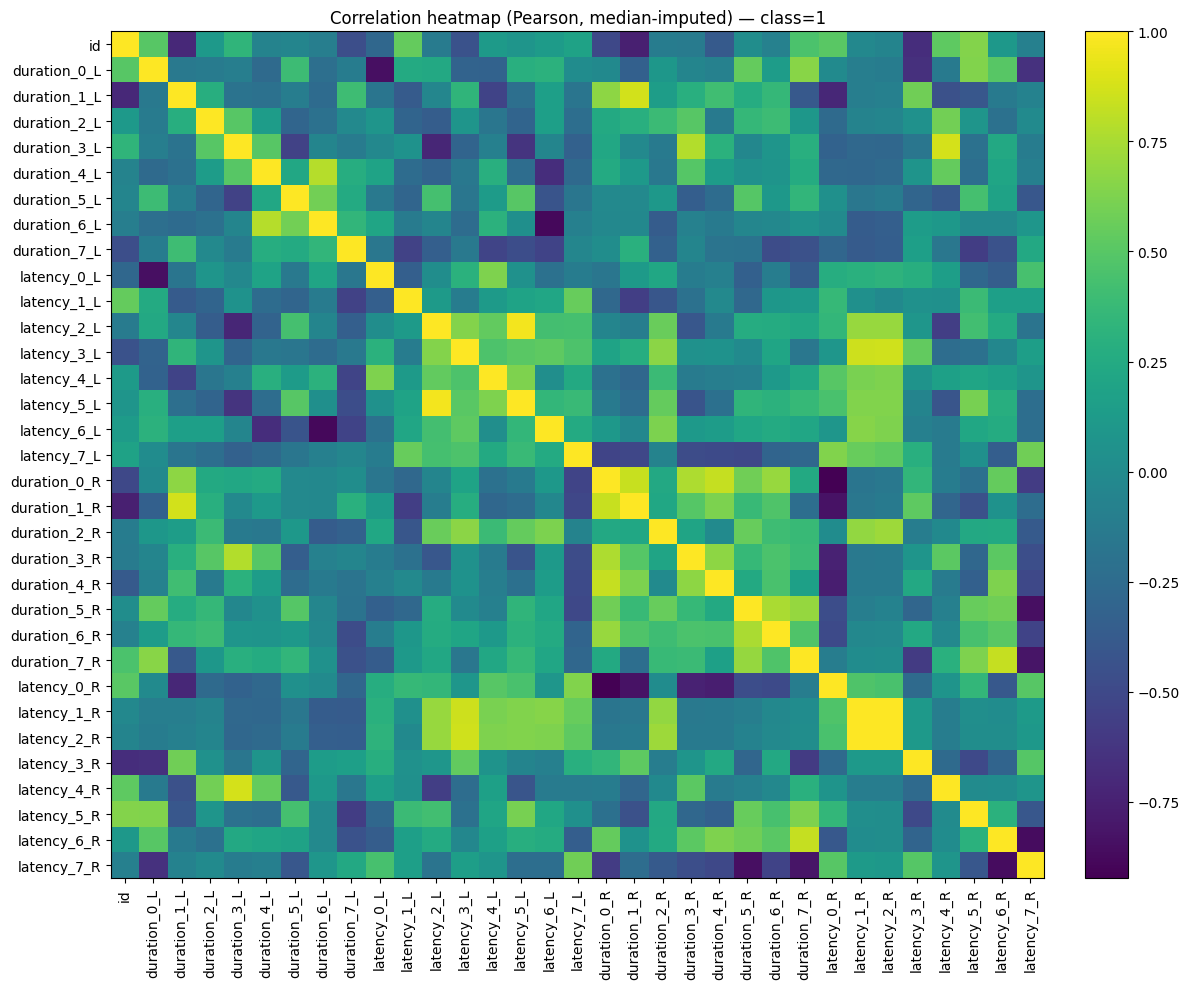

In [ ]:
df = pd.read_csv('df.csv')

cands = {"disease","diagnosis","diag","label","target","class","y","pd_et","pd-et","pd/et"}
lower = {c.lower(): c for c in df.columns}
target_col = next((lower[k] for k in cands if k in lower), None)

if target_col is None:
    nums = [c for c in df.columns if is_numeric_dtype(df[c])]
    for c in nums:
        u = pd.Series(df[c].dropna().unique())
        try:
            u = u.astype(float)
        except Exception:
            continue
        s = set(u.tolist())
        if s.issubset({0.0, 1.0}) and len(s) == 2:
            target_col = c
            break
assert target_col is not None, "Не нашёл столбец с меткой (0/1)."

X_all = df.select_dtypes(include=[np.number]).copy()
if target_col in X_all.columns:
    X_all = X_all.drop(columns=[target_col])

def plot_class_corr(df_all, y_col, cls, out_path):
    sub = df_all[df_all[y_col] == cls]
    X = sub[X_all.columns].copy()
    imp = SimpleImputer(strategy='median')
    X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns, index=X.index)
    C = X_imp.corr(method='pearson')

    plt.figure(figsize=(12, 10))
    img = plt.imshow(C.values, aspect='auto', interpolation='nearest')
    plt.title(f'Correlation heatmap (Pearson, median-imputed) — class={cls}')
    plt.xticks(ticks=np.arange(C.shape[1]), labels=C.columns, rotation=90)
    plt.yticks(ticks=np.arange(C.shape[0]), labels=C.index)
    plt.colorbar(img, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200, bbox_inches='tight')
    plt.show()

plot_class_corr(df, target_col, 0, 'corr_heatmap_imputed_PD.png')
plot_class_corr(df, target_col, 1, 'corr_heatmap_imputed_ET.png')


## Metrics

In [ ]:
TARGET_COL = 'disease'   # 0=PD, 1=ET
USE_DURATION = True

df = pd.read_csv('df.csv')
df.rename(columns=lambda s: s.strip() if isinstance(s, str) else s, inplace=True)
assert TARGET_COL in df.columns, "В df нет столбца 'disease'"
y = df[TARGET_COL].astype(int)

In [ ]:
def find_metric_columns(frame, metric):
    pat = re.compile(rf'^{re.escape(metric)}_(\d+)_([LR])$', re.IGNORECASE)
    by_eye = {'L': {}, 'R': {}}
    for c in frame.columns:
        m = pat.match(str(c))
        if m:
            imp = int(m.group(1))
            side = m.group(2).upper()
            by_eye[side][imp] = c
    imps_L = sorted(by_eye['L'].keys())
    imps_R = sorted(by_eye['R'].keys())
    return by_eye, imps_L, imps_R

def row_lin_slope(vals, xs):
    mask = np.isfinite(vals)
    if mask.sum() < 2:
        return np.nan
    x = xs[mask].astype(float)
    y = vals[mask].astype(float)
    x = x-x.mean()
    y = y-y.mean()
    denom = np.sum(x*x)
    return float(np.dot(y, x) / denom) if denom != 0 else 0.0

def row_quad_coeff(vals, xs):
    mask = np.isfinite(vals)
    if mask.sum() < 3:
        return np.nan
    x = xs[mask].astype(float)
    y = vals[mask].astype(float)
    if x.max() == x.min():
        return 0.0
    xn = 2*(x - x.min())/(x.max() - x.min()) - 1.0
    try:
        a2, a1, a0 = np.polyfit(xn, y, deg=2)
        return float(a2)
    except Exception:
        return np.nan

def safe_ratio(a, b, eps=1e-9):
    if not np.isfinite(a) or not np.isfinite(b):
        return np.nan
    return float(b / (a + eps))

def add_asymmetry(df_out, base_name_L, base_name_R, out_name, eps=1e-9):
    if base_name_L in df_out.columns and base_name_R in df_out.columns:
        L = pd.to_numeric(df_out[base_name_L], errors='coerce')
        R = pd.to_numeric(df_out[base_name_R], errors='coerce')
        df_out[out_name] = (R - L) / (R + L + eps)

def build_dynamic_features(frame, metric):
    by_eye, imps_L, imps_R = find_metric_columns(frame, metric)
    feats = pd.DataFrame(index=frame.index)

    for eye, imps in [('L', imps_L), ('R', imps_R)]:
        if not imps:
            continue
        cols = [by_eye[eye][i] for i in imps]
        mat= frame[cols].to_numpy(dtype=float)
        xs = np.asarray(imps, dtype=float)

        first_vals = np.nan
        last_vals = np.nan
        first_vals = pd.to_numeric(frame[by_eye[eye][imps[0]]], errors='coerce').to_numpy(dtype=float)
        last_vals = pd.to_numeric(frame[by_eye[eye][imps[-1]]], errors='coerce').to_numpy(dtype=float)
        mean_vals = np.nanmean(mat, axis=1)
        median_vals = np.nanmedian(mat, axis=1)
        std_vals = np.nanstd(mat, axis=1, ddof=0)
        cv_vals = std_vals / (np.abs(mean_vals) + 1e-9)
        slopes = np.array([row_lin_slope(row, xs) for row in mat], dtype=float)
        quads= np.array([row_quad_coeff(row, xs) for row in mat], dtype=float)
        deltas = last_vals - first_vals
        ratios = np.array([safe_ratio(a, b) for a, b in zip(first_vals, last_vals)], dtype=float)

        feats[f'{metric}_first_{eye}'] = first_vals
        feats[f'{metric}_last_{eye}'] = last_vals
        feats[f'{metric}_delta_{eye}'] = deltas
        feats[f'{metric}_ratio_{eye}'] = ratios
        feats[f'{metric}_mean_{eye}'] = mean_vals
        feats[f'{metric}_median_{eye}'] = median_vals
        feats[f'{metric}_std_{eye}'] = std_vals
        feats[f'{metric}_cv_{eye}'] = cv_vals
        feats[f'{metric}_slope_{eye}'] = slopes
        feats[f'{metric}_quad_{eye}'] = quads

    aggs = ['first','last','delta','ratio','mean','median','std','cv','slope','quad']
    for agg in aggs:
        add_asymmetry(feats, f'{metric}_{agg}_L', f'{metric}_{agg}_R', f'{metric}_{agg}_SI')

    return feats

In [ ]:
feat_lat = build_dynamic_features(df, 'latency')
if USE_DURATION:
    feat_dur = build_dynamic_features(df, 'duration')
    X = pd.concat([feat_lat, feat_dur], axis=1)
else:
    X = feat_lat.copy()


X = X.select_dtypes(include=[np.number])
pipe = Pipeline([('impute', SimpleImputer(strategy='median')), ('model', GaussianNB())])

param_grid = {'model__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]}
cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
gs = GridSearchCV(pipe, param_grid, cv=cv_inner, scoring='roc_auc', n_jobs=-1)

cv_outer = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)
rng = np.random.RandomState(42)
perm = rng.permutation(len(y))
X = X.iloc[perm].reset_index(drop=True)
y = y.iloc[perm].reset_index(drop=True)

fold_aucs = []
oof_scores = np.full(len(y), np.nan, float)
oof_preds  = np.full(len(y), np.nan, float)

for tr, te in cv_outer.split(X, y):
    gs.fit(X.iloc[tr], y.iloc[tr])
    best = gs.best_estimator_
    s = best.predict_proba(X.iloc[te])[:, 1]
    p = (s >= 0.5).astype(int)
    oof_scores[te] = s
    oof_preds[te]  = p
    fold_aucs.append(roc_auc_score(y.iloc[te], s))

fold_aucs = np.asarray(fold_aucs, float)
nested_mean_auc, nested_std_auc = fold_aucs.mean(), fold_aucs.std()


/tmp/ipython-input-1830716933.py:66: RuntimeWarning: Mean of empty slice
  mean_vals = np.nanmean(mat, axis=1)
/tmp/ipython-input-1830716933.py:67: RuntimeWarning: All-NaN slice encountered
  median_vals = np.nanmedian(mat, axis=1)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-1830716933.py:66: RuntimeWarning: Mean of empty slice
  mean_vals = np.nanmean(mat, axis=1)
/tmp/ipython-input-1830716933.py:67: RuntimeWarning: All-NaN slice encountered
  median_vals = np.nanmedian(mat, axis=1)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-1830716933.py:66: RuntimeWarning: Mean of empty slice
  mean_vals = np.nanmean(mat, axis=1)
/tmp/ipython-input-1830716933.py:67: Runtim

In [ ]:
def bootstrap_auc_ci(y_true, y_score, n_boot=4000, random_state=1):
    rs = np.random.RandomState(random_state)
    n = len(y_true); idx = np.arange(n)
    aucs = []
    for i in range(n_boot):
        s = rs.choice(idx, size=n, replace=True)
        yt, ys = y_true[s], y_score[s]
        if len(np.unique(yt)) < 2:
            continue
        aucs.append(roc_auc_score(yt, ys))
    if not aucs:
        return (np.nan, np.nan)
    return (np.percentile(aucs, 2.5), np.percentile(aucs, 97.5))

oof_auc = roc_auc_score(y, oof_scores)
oof_ap  = average_precision_score(y, oof_scores)
acc     = accuracy_score(y, oof_preds)
bacc    = balanced_accuracy_score(y, oof_preds)
prec    = precision_score(y, oof_preds, zero_division=0)
rec     = recall_score(y, oof_preds, zero_division=0)
f1      = f1_score(y, oof_preds, zero_division=0)
cm      = confusion_matrix(y, oof_preds, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
spec    = tn / (tn + fp) if (tn + fp) else np.nan
brier   = brier_score_loss(y, oof_scores)
try:
    ll = log_loss(y, np.c_[1 - oof_scores, oof_scores], labels=[0, 1])
except Exception:
    ll = np.nan

ci_lo, ci_hi = bootstrap_auc_ci(y.to_numpy(), oof_scores, n_boot=2000, random_state=1)

print("=== GaussianNB на динамических фичах (latency{} ) ===".format(" + duration" if USE_DURATION else ""))
print("Число признаков:", X.shape[1])
print(f"Nested ROC-AUC: {nested_mean_auc:.3f} ± {nested_std_auc:.3f}")
print(f"OOF ROC-AUC: {oof_auc:.3f} (95% CI {ci_lo:.3f}..{ci_hi:.3f})")
print(f"OOF PR-AUC: {oof_ap:.3f}")
print(f"Accuracy: {acc:.3f}")
print(f"Balanced Acc: {bacc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall (TPR): {rec:.3f}")
print(f"Specificity: {spec:.3f}")
print(f"F1-score: {f1:.3f}")
print("Confusion matrix [rows=true PD=0/ET=1, cols=pred]:")
print(cm)
print(f"Brier score: {brier:.3f}")
print(f"Log loss: {ll:.3f}")

out_path = 'gnb_oof_dynamic.csv'
pd.DataFrame({'y_true': y, 'score': oof_scores, 'pred_0.5': oof_preds}).to_csv(out_path, index=False)
print("OOF предсказания сохранены в:", out_path)

=== GaussianNB на динамических фичах (latency + duration ) ===
Число признаков: 60
Nested ROC-AUC: 0.495 ± 0.274
OOF ROC-AUC: 0.503 (95% CI 0.250..0.764)
OOF PR-AUC: 0.511
Accuracy: 0.630
Balanced Acc: 0.541
Precision: 0.500
Recall (TPR): 0.200
Specificity: 0.882
F1-score: 0.286
Confusion matrix [rows=true PD=0/ET=1, cols=pred]:
[[15  2]
 [ 8  2]]
Brier score: 0.370
Log loss: 2.981
OOF предсказания сохранены в: gnb_oof_dynamic.csv


In [ ]:
df = pd.read_csv('df.csv')
df.rename(columns=lambda s: s.strip() if isinstance(s, str) else s, inplace=True)

cands = {"disease","diagnosis","diag","label","target","class","y","pd_et","pd-et","pd/et"}
lower = {c.lower(): c for c in df.columns}
target_col = next((lower[k] for k in cands if k in lower), None)
if target_col is None:
    for c in df.columns:
        try:
            vals = pd.to_numeric(df[c], errors='coerce').dropna().unique().astype(float)
        except Exception:
            continue
        s = set(vals.tolist())
        if s.issubset({0.0, 1.0}) and len(s) == 2:
            target_col = c
            break
assert target_col is not None, "Не найден столбец меток (например, 'disease')"
y = df[target_col].astype(int)

lat_pat = re.compile(r'^latency_(\d+)_([LR])$', re.IGNORECASE)
lat_cols = []
for c in df.columns:
    m = lat_pat.match(str(c))
    if m:
        imp = int(m.group(1)); side = m.group(2).upper()
        lat_cols.append((c, imp, side))
assert lat_cols, "Не найдено колонок вида latency_{i}_{L/R}"

by_eye = {'L': {}, 'R': {}}
for cname, imp, side in lat_cols:
    by_eye[side][imp] = cname

imps_L = sorted(by_eye['L'].keys())
imps_R = sorted(by_eye['R'].keys())
assert len(imps_L) >= 2 or len(imps_R) >= 2, "Нужно как минимум 2 импульса на глаз"

In [ ]:
def linear_slope_along_axis(M, idx):
    idx = np.asarray(idx, dtype=float)
    x = idx - idx.mean()
    denom = (x**2).sum() if (x**2).sum() != 0 else 1.0
    y = M.astype(float)
    y = y - np.nanmean(y, axis=1, keepdims=True)
    y = np.nan_to_num(y, nan=0.0)
    num = np.dot(y, x)
    return num / denom

def cliffs_delta(a, b):
    a = np.asarray(a); b = np.asarray(b)
    a = a[np.isfinite(a)]; b = b[np.isfinite(b)]
    if len(a)==0 or len(b)==0:
        return np.nan
    gt = 0; lt = 0
    for x in a:
        gt += np.sum(x > b)
        lt += np.sum(x < b)
    return (gt - lt) / (len(a)*len(b))

def fdr_bh(p):
    p = np.asarray(p, dtype=float)
    n = p.size
    order = np.argsort(p)
    ranked = p[order]
    adj = np.empty_like(ranked)
    prev = 1.0
    for i in range(n-1, -1, -1):
        val = ranked[i] * n / (i+1)
        if not np.isfinite(val):
            val = 1.0
        adj[i] = min(prev, val)
        prev = adj[i]
    out = np.empty_like(adj); out[order] = adj
    return out

In [ ]:
feat_rows = []
for idx, row in df.iterrows():
    rec = { 'idx': idx, 'disease': int(row[target_col]) }
    if len(imps_L) >= 2:
        arrL = row[[by_eye['L'][i] for i in imps_L]].astype(float).to_numpy()
        rec['delta_0_{}_L'.format(imps_L[-1])] = arrL[0] - arrL[-1] if np.isfinite(arrL[0]) and np.isfinite(arrL[-1]) else np.nan
        rec['slope_L'] = linear_slope_along_axis(arrL.reshape(1, -1), np.array(imps_L))[0]
    else:
        rec['delta_0_{}_L'.format(imps_L[-1] if imps_L else 7)] = np.nan
        rec['slope_L'] = np.nan


    if len(imps_R) >= 2:
        arrR = row[[by_eye['R'][i] for i in imps_R]].astype(float).to_numpy()
        rec['delta_0_{}_R'.format(imps_R[-1])] = arrR[0] - arrR[-1] if np.isfinite(arrR[0]) and np.isfinite(arrR[-1]) else np.nan
        rec['slope_R'] = linear_slope_along_axis(arrR.reshape(1, -1), np.array(imps_R))[0]
    else:
        rec['delta_0_{}_R'.format(imps_R[-1] if imps_R else 7)] = np.nan
        rec['slope_R'] = np.nan
    feat_rows.append(rec)

metrics_df = pd.DataFrame(feat_rows)
metric_cols = [c for c in metrics_df.columns if c not in ('idx','disease')]

/tmp/ipython-input-3848195795.py:6: RuntimeWarning: Mean of empty slice
  y = y - np.nanmean(y, axis=1, keepdims=True)
/tmp/ipython-input-3848195795.py:6: RuntimeWarning: Mean of empty slice
  y = y - np.nanmean(y, axis=1, keepdims=True)
/tmp/ipython-input-3848195795.py:6: RuntimeWarning: Mean of empty slice
  y = y - np.nanmean(y, axis=1, keepdims=True)
/tmp/ipython-input-3848195795.py:6: RuntimeWarning: Mean of empty slice
  y = y - np.nanmean(y, axis=1, keepdims=True)
/tmp/ipython-input-3848195795.py:6: RuntimeWarning: Mean of empty slice
  y = y - np.nanmean(y, axis=1, keepdims=True)
/tmp/ipython-input-3848195795.py:6: RuntimeWarning: Mean of empty slice
  y = y - np.nanmean(y, axis=1, keepdims=True)


In [ ]:
rows = []
mask_pd = metrics_df['disease'] == 0
mask_et = metrics_df['disease'] == 1

for c in metric_cols:
    x0 = pd.to_numeric(metrics_df.loc[mask_pd, c], errors='coerce').dropna().values
    x1 = pd.to_numeric(metrics_df.loc[mask_et, c], errors='coerce').dropna().values
    auc = np.nan
    try:
        tmp = metrics_df[[c, 'disease']].dropna()
        if tmp['disease'].nunique() == 2 and len(tmp) >= 5:
            auc = roc_auc_score(tmp['disease'].astype(int), tmp[c].astype(float))
    except Exception:
        pass
    auc_abs = np.nan if not np.isfinite(auc) else max(auc, 1-auc)

    # Mann–Whitney
    p_mw = np.nan
    try:
        if len(x0) >= 2 and len(x1) >= 2:
            i, p_mw = mannwhitneyu(x0, x1, alternative='two-sided')
    except Exception:
        pass

    # Brunner–Munzel
    p_bm = np.nan
    try:
        if len(x0) >= 2 and len(x1) >= 2:
            i, p_bm = brunnermunzel(x0, x1, alternative='two-sided')
    except Exception:
        pass

    cd = cliffs_delta(x0, x1)

    rows.append(dict(metric=c, n_PD=len(x0), n_ET=len(x1), auc=auc,
                     auc_abs=auc_abs, mw_p=p_mw, bm_p=p_bm, cliffs_delta=cd))

res = pd.DataFrame(rows)

for col in ['mw_p', 'bm_p']:
    mask = res[col].notna()
    res[col + '_fdr'] = np.nan
    if mask.any():
        res.loc[mask, col + '_fdr'] = fdr_bh(res.loc[mask, col].values)


res['auc_gap'] = res['auc_abs'] - 0.5
res_sorted = res.sort_values(['auc_gap', 'cliffs_delta'], ascending=[False, False]).reset_index(drop=True)

print("Сводка по метрикам динамики латентности (PD vs ET)")
print(res_sorted[['metric','auc','mw_p','mw_p_fdr','bm_p','bm_p_fdr','cliffs_delta']].to_string(index=False))

#res_sorted.to_csv('pd_et_latency_dynamics_tests.csv', index=False)
#print("\nФайл сохранён: pd_et_latency_dynamics_tests.csv")


Сводка по метрикам динамики латентности (PD vs ET)
     metric      auc     mw_p  mw_p_fdr     bm_p  bm_p_fdr  cliffs_delta
    slope_R 0.670588 0.152187  0.436730 0.121829  0.409310     -0.341176
    slope_L 0.647059 0.218365  0.436730 0.204655  0.409310     -0.294118
delta_0_7_L 0.389423 0.425517  0.567356 0.398312  0.531083      0.221154
delta_0_7_R 0.390625 0.609759  0.609759 0.542385  0.542385      0.218750


In [ ]:
df = pd.read_csv('df.csv')
df.rename(columns=lambda s: s.strip() if isinstance(s, str) else s, inplace=True)

target_candidates = {"disease","diagnosis","diag","label","target","class","y","pd_et","pd-et","pd/et"}
lower = {c.lower(): c for c in df.columns}
target_col = next((lower[k] for k in target_candidates if k in lower), None)
if target_col is None:
    for c in df.columns:
        if is_numeric_dtype(df[c]):
            vals = pd.to_numeric(df[c], errors='coerce').dropna().unique()
            try:
                s = set(vals.astype(float).tolist())
            except Exception:
                continue
            if s.issubset({0.0, 1.0}) and len(s) == 2:
                target_col = c
                break
assert target_col is not None, "Не найден столбец меток (например, 'disease')"

lat_pat = re.compile(r'^latency_(\d+)_([LR])$', re.IGNORECASE)
by_eye = {'L': {}, 'R': {}}
for c in df.columns:
    m = lat_pat.match(str(c))
    if m:
        imp = int(m.group(1)); eye = m.group(2).upper()
        by_eye[eye][imp] = c

imps_L = sorted(by_eye['L'].keys())
imps_R = sorted(by_eye['R'].keys())
assert (len(imps_L) >= 2) or (len(imps_R) >= 2), "Нужно >=2 импульсов хотя бы для одного глаза"

In [ ]:
def fdr_bh(pvals):
    p = np.asarray(pvals, dtype=float)
    n = p.size
    order = np.argsort(p)
    ranked = p[order]
    adj = np.empty_like(ranked)
    prev = 1.0
    for i in range(n-1, -1, -1):
        val = ranked[i] * n / (i+1)
        if not np.isfinite(val):
            val = 1.0
        adj[i] = min(prev, val)
        prev = adj[i]
    out = np.empty_like(adj)
    out[order] = adj
    return out

def run_adjacent(df_sub, eye, impulses):
    rows = []
    for i, j in zip(impulses[:-1], impulses[1:]):
        c1, c2 = by_eye[eye][i], by_eye[eye][j]
        x = pd.to_numeric(df_sub[c1], errors='coerce')
        y = pd.to_numeric(df_sub[c2], errors='coerce')
        mask = x.notna() & y.notna()
        xv, yv = x[mask].to_numpy(dtype=float), y[mask].to_numpy(dtype=float)

        n_pairs = len(xv)
        if n_pairs < 1:
            rows.append(dict(eye=eye, comparison=f"{i}→{j}", n_pairs=n_pairs,
                             median_diff=np.nan, p_two_sided=np.nan, p_decrease=np.nan))
            continue

        med_diff = float(np.nanmedian(xv - yv))

        def safe_wilcoxon(a, b, alternative):
            try:
                res = wilcoxon(a, b, alternative=alternative, zero_method='wilcox', method='auto')
                return float(res.pvalue)
            except Exception:
                return np.nan

        p2 = safe_wilcoxon(xv, yv, 'two-sided')
        p1 = safe_wilcoxon(xv, yv, 'greater')

        rows.append(dict(eye=eye, comparison=f"{i}→{j}", n_pairs=n_pairs,
                         median_diff=med_diff, p_two_sided=p2, p_decrease=p1))
    return rows


In [ ]:
results = []
for grp_val, grp_name in [(0, 'PD'), (1, 'ET')]:
    df_g = df[df[target_col] == grp_val]
    if len(imps_L) >= 2:
        results += [dict(group=grp_name, **row) for row in run_adjacent(df_g, 'L', imps_L)]
    if len(imps_R) >= 2:
        results += [dict(group=grp_name, **row) for row in run_adjacent(df_g, 'R', imps_R)]

res = pd.DataFrame(results, columns=[
    'group','eye','comparison','n_pairs','median_diff','p_two_sided','p_decrease'
])

padj_two_all, padj_dec_all = [], []
for (g,e), block in res.groupby(['group','eye'], sort=False):
    p2 = block['p_two_sided'].to_numpy()
    p1 = block['p_decrease'].to_numpy()
    m2 = ~np.isnan(p2)
    m1 = ~np.isnan(p1)
    padj2 = fdr_bh(p2[m2]) if m2.any() else np.array([])
    padj1 = fdr_bh(p1[m1]) if m1.any() else np.array([])
    it2, it1 = iter(padj2), iter(padj1)
    for i in range(len(block)):
        padj_two_all.append(next(it2) if m2[i] else np.nan)
        padj_dec_all.append(next(it1) if m1[i] else np.nan)

res['p_two_sided_fdr'] = padj_two_all
res['p_decrease_fdr']  = padj_dec_all

res['from_imp'] = res['comparison'].str.extract(r'^(\d+)').astype(float)
res.sort_values(['group','eye','from_imp'], inplace=True)
res.drop(columns=['from_imp'], inplace=True)

out_csv = 'wilcoxon_adjacent_PD_ET.csv'
res.to_csv(out_csv, index=False)

print("Сохранено в:", out_csv)
print("\nЗначимые (<=0.05) уменьшения по группам и глазам:") #FDR<=0.05
sig = res[res['p_decrease_fdr'].notna() & (res['p_decrease_fdr'] <= 0.05)]
if len(sig) == 0:
    print("— Нет значимых соседних уменьшений после FDR.")
else:
    print(sig[['group','eye','comparison','n_pairs','median_diff','p_decrease','p_decrease_fdr']].to_string(index=False))

print("\nОбщая таблица:")
print(res.to_string(index=False))

Сохранено в: wilcoxon_adjacent_PD_ET.csv

Значимые (<=0.05) уменьшения по группам и глазам:
group eye comparison  n_pairs  median_diff  p_decrease  p_decrease_fdr
   ET   L        1→2        8         40.0    0.003906        0.027344
   PD   L        4→5       14         86.0    0.002138        0.014967

Общая таблица:
group eye comparison  n_pairs  median_diff  p_two_sided  p_decrease  p_two_sided_fdr  p_decrease_fdr
   ET   L        0→1        7        -20.0     0.812500    0.656250         0.820312        0.918750
   ET   L        1→2        8         40.0     0.007812    0.003906         0.054688        0.027344
   ET   L        2→3        8        -26.0     0.117188    0.949219         0.410156        0.949219
   ET   L        3→4        8         11.0     0.640625    0.320312         0.820312        0.847656
   ET   L        4→5        9         -8.0     0.820312    0.632812         0.820312        0.918750
   ET   L        5→6        9         -2.0     0.726562    0.363281      

## Saccade approximation

In [ ]:
PATH = 'df.csv'
N_BOOT = 500
RANDOM_STATE = 42

df = pd.read_csv('df.csv')
df.rename(columns=lambda s: s.strip() if isinstance(s, str) else s, inplace=True)

assert 'disease' in df.columns, "Нет столбца 'disease' (0=PD, 1=ET)"
y = df['disease'].astype(int)

lat_pat = re.compile(r'^latency_(\d+)_([LR])$', re.IGNORECASE)
by_eye = {'L': {}, 'R': {}}
for c in df.columns:
    m = lat_pat.match(str(c))
    if m:
        imp = int(m.group(1)); eye = m.group(2).upper()
        by_eye[eye][imp] = c

imps = {eye: sorted(by_eye[eye].keys()) for eye in ['L','R']}
assert any(len(imps[eye]) >= 3 for eye in ['L','R']), "Нужно >=3 импульсов хотя бы для одного глаза"


In [ ]:
def exp_model(x, a, b, tau):
    return a + b * np.exp(-x / np.maximum(tau, 1e-8))

def logistic_decreasing(x, L, U, x0, s):
    return L + (U - L) / (1.0 + np.exp((x - x0) / np.maximum(s, 1e-8)))

def group_eye_matrix(frame, grp_mask, eye):
    idx = imps[eye]
    cols = [by_eye[eye][i] for i in idx]
    M = frame.loc[grp_mask, cols].to_numpy(dtype=float)
    x = np.asarray(idx, dtype=float)
    return x, M

def robust_curve_fit(x, y, kind='exp'):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    if len(x) < 3:
        return None, None

    if kind == 'exp':
        a0 = float(np.nanmin(y))
        b0 = float(np.nanmax(y) - a0)
        tau0 = 2.0
        try:
            popt, _ = curve_fit(
                exp_model, x, y,
                p0=[a0, b0, tau0],
                bounds=([-np.inf, -np.inf, 1e-6], [np.inf, np.inf, 1e3]),
                maxfev=10000
            )
            return popt, lambda t: exp_model(np.asarray(t, float), *popt)
        except Exception:
            return None, None

    if kind == 'logistic':
        L0 = float(np.nanmin(y))
        U0 = float(np.nanmax(y))
        x0_0 = float(np.median(x))
        s0 = 1.0
        try:
            popt, i = curve_fit(
                logistic_decreasing, x, y,
                p0=[L0, U0, x0_0, s0],
                bounds=([-np.inf, -np.inf, np.min(x)-5, 1e-6], [np.inf, np.inf, np.max(x)+5, 1e3]),
                maxfev=10000
            )
            return popt, lambda t: logistic_decreasing(np.asarray(t, float), *popt)
        except Exception:
            return None, None

    return None, None

def bootstrap_tau(group_df, eye, n_boot=N_BOOT, rng=None):
    if rng is None:
        rng = np.random.default_rng(RANDOM_STATE)
    x_idx = imps[eye]
    cols = [by_eye[eye][i] for i in x_idx]
    X = group_df[cols].to_numpy(float)
    taus = []
    n = X.shape[0]
    x = np.asarray(x_idx, float)

    for _ in range(n_boot):
        if n == 0:
            break
        sidx = rng.integers(0, n, size=n)
        M = X[sidx, :]
        med = np.nanmedian(M, axis=0)
        params, _ = robust_curve_fit(x, med, kind='exp')
        if params is not None:
            taus.append(float(params[2]))
    if len(taus) == 0:
        return np.nan, (np.nan, np.nan)
    tau_hat = float(np.median(taus))
    lo, hi = np.percentile(taus, [2.5, 97.5])
    return tau_hat, (float(lo), float(hi))

def plot_fit(x, y_med, model_fun, title="", annotate="", out_path=None):
    plt.style.use('seaborn-v0_8-whitegrid')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.scatter(x, y_med, s=80, color='black')

    if model_fun is not None:
        xs = np.linspace(min(x), max(x), 300)
        ax.plot(xs, model_fun(xs), linewidth=3)

    ax.set_title(title, fontsize=20, fontweight='bold')
    ax.set_xlabel("Impulse index", fontsize=17)
    ax.set_ylabel("Median amplitude", fontsize=17)

    ax.spines['bottom'].set_linewidth(1.8)
    ax.spines['left'].set_linewidth(1.8)

    ax.tick_params(axis='both', labelsize=15)

    if annotate:
        ax.text(
            0.05, 0.95, annotate,
            transform=ax.transAxes,
            fontsize=15,
            verticalalignment='top'
        )

    plt.tight_layout()

    if out_path:
        fig.savefig(out_path, dpi=200)

    plt.show()

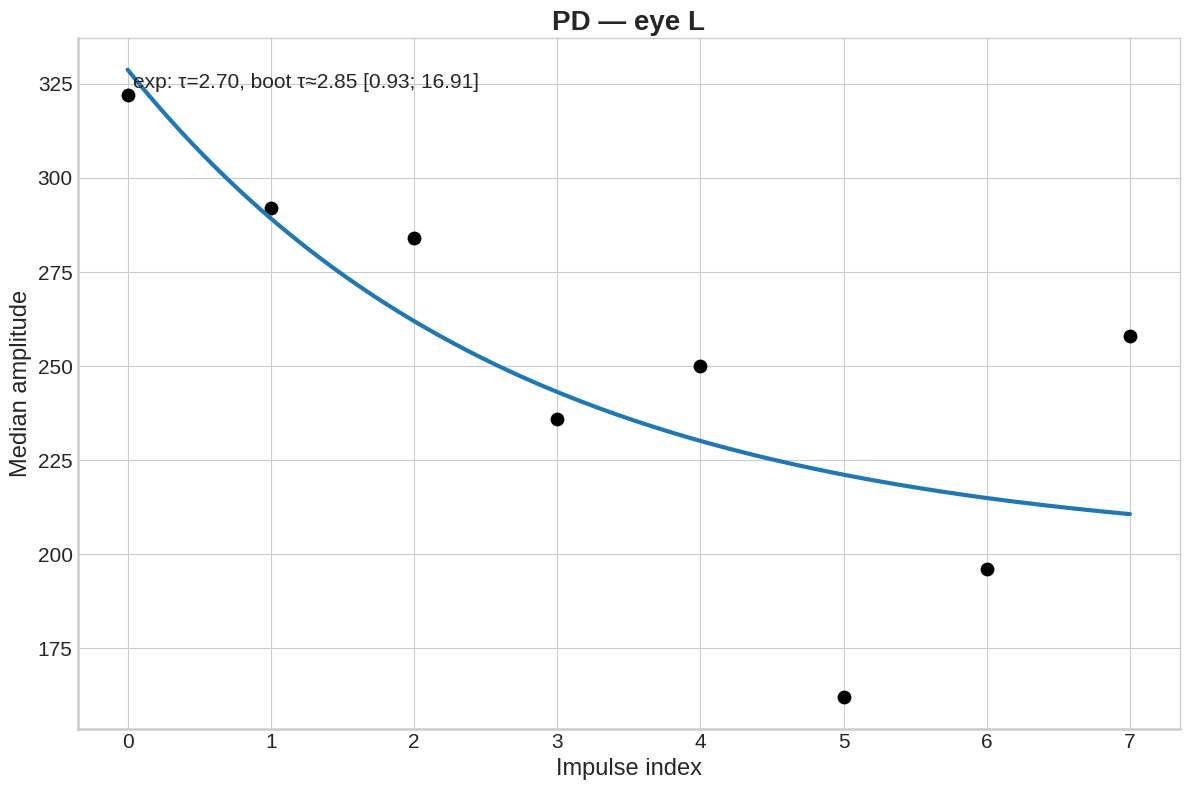

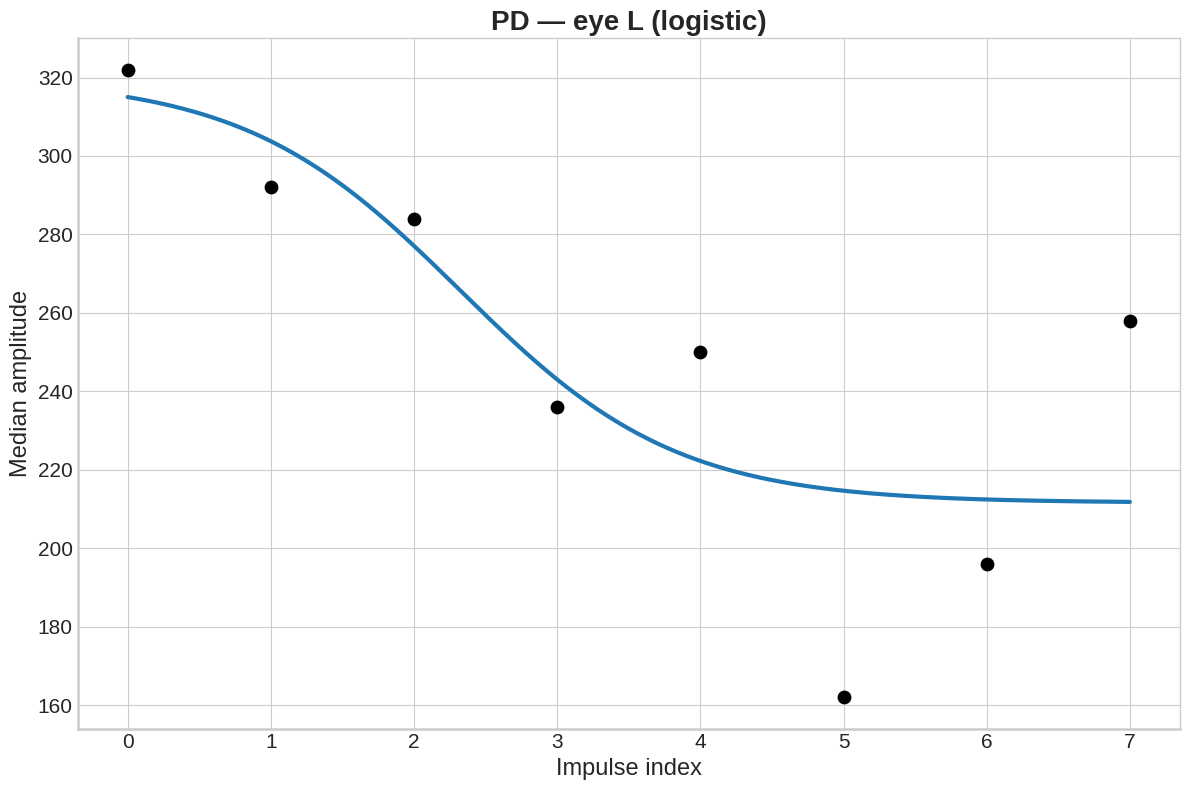

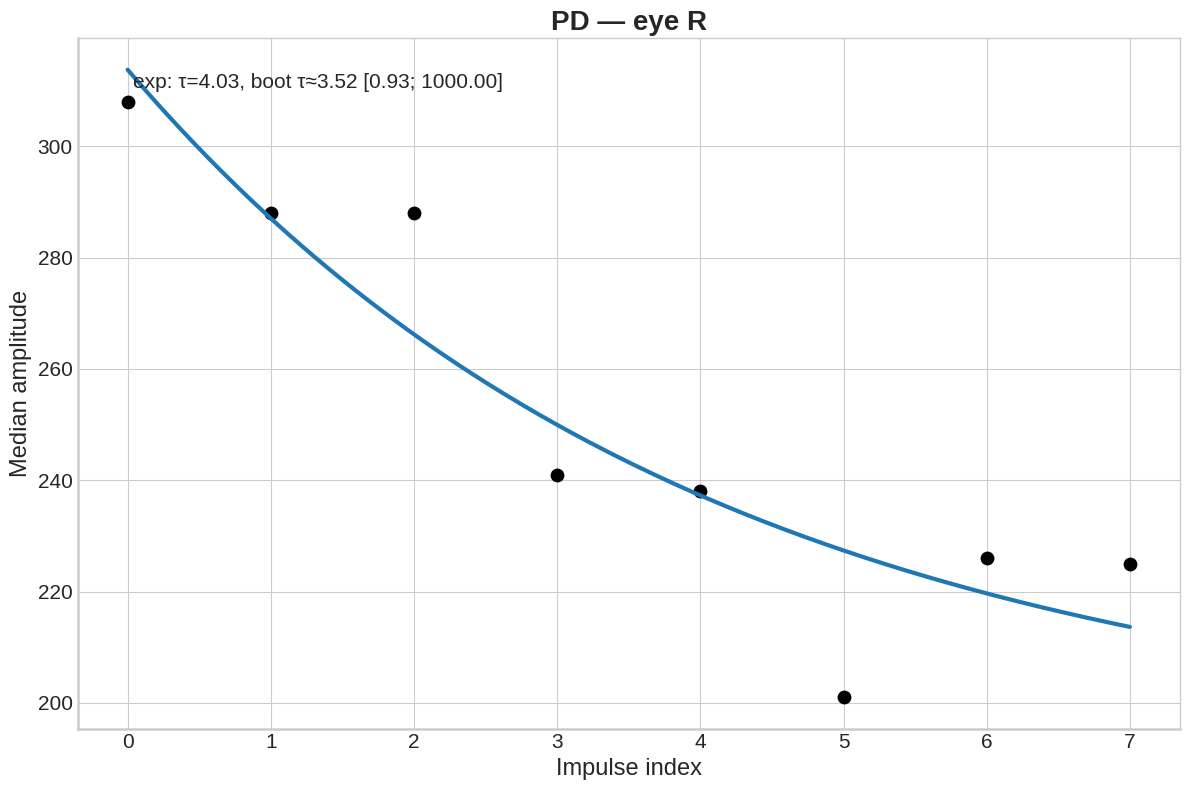

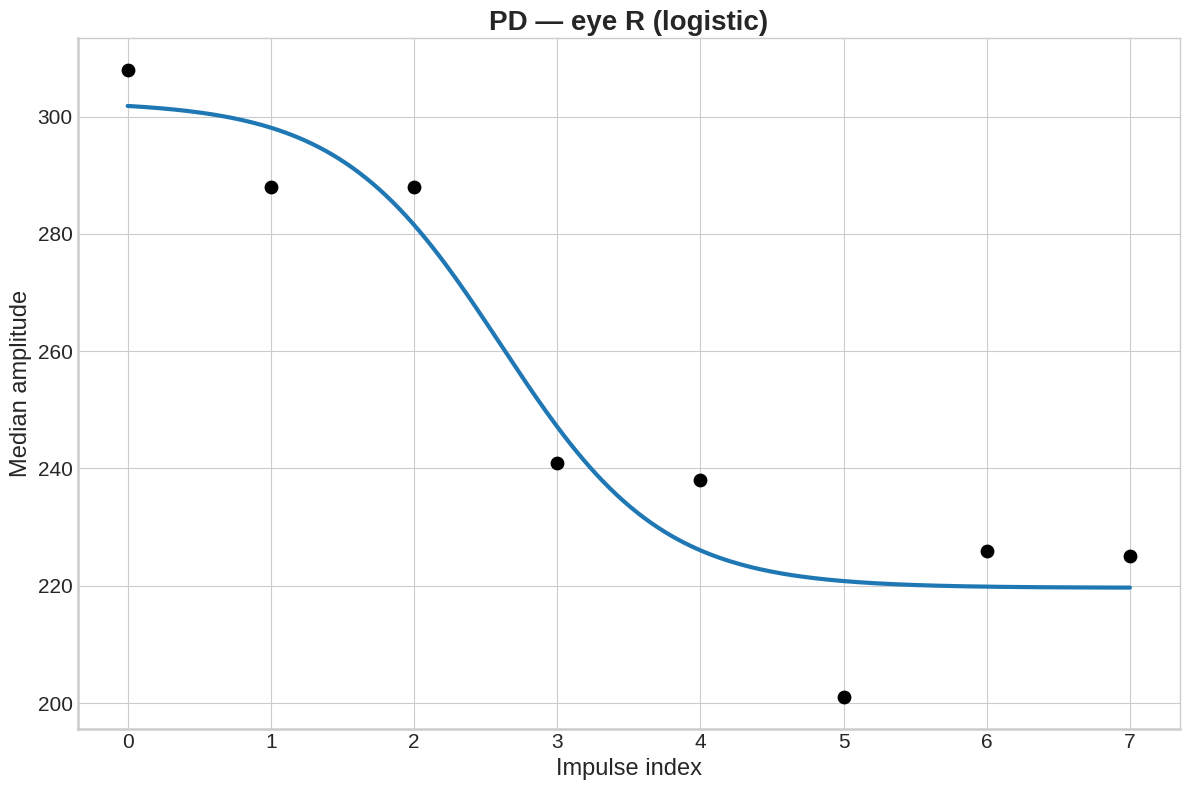

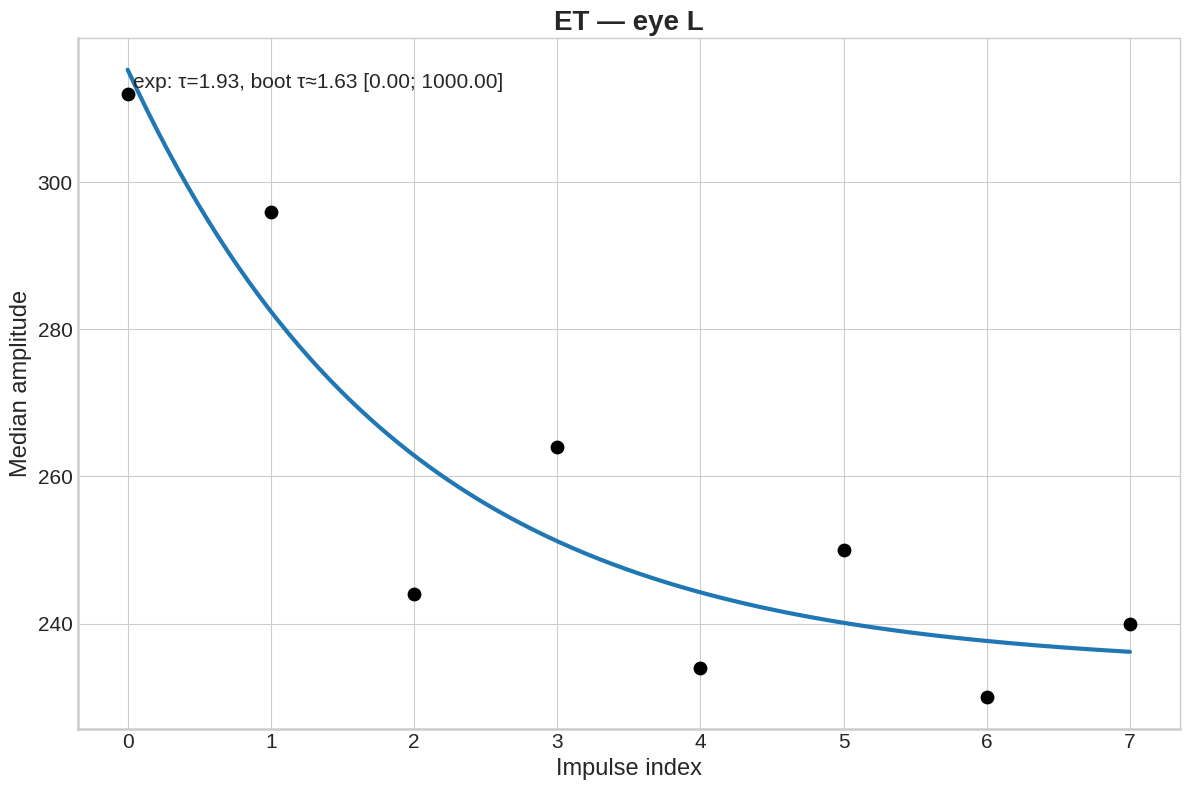

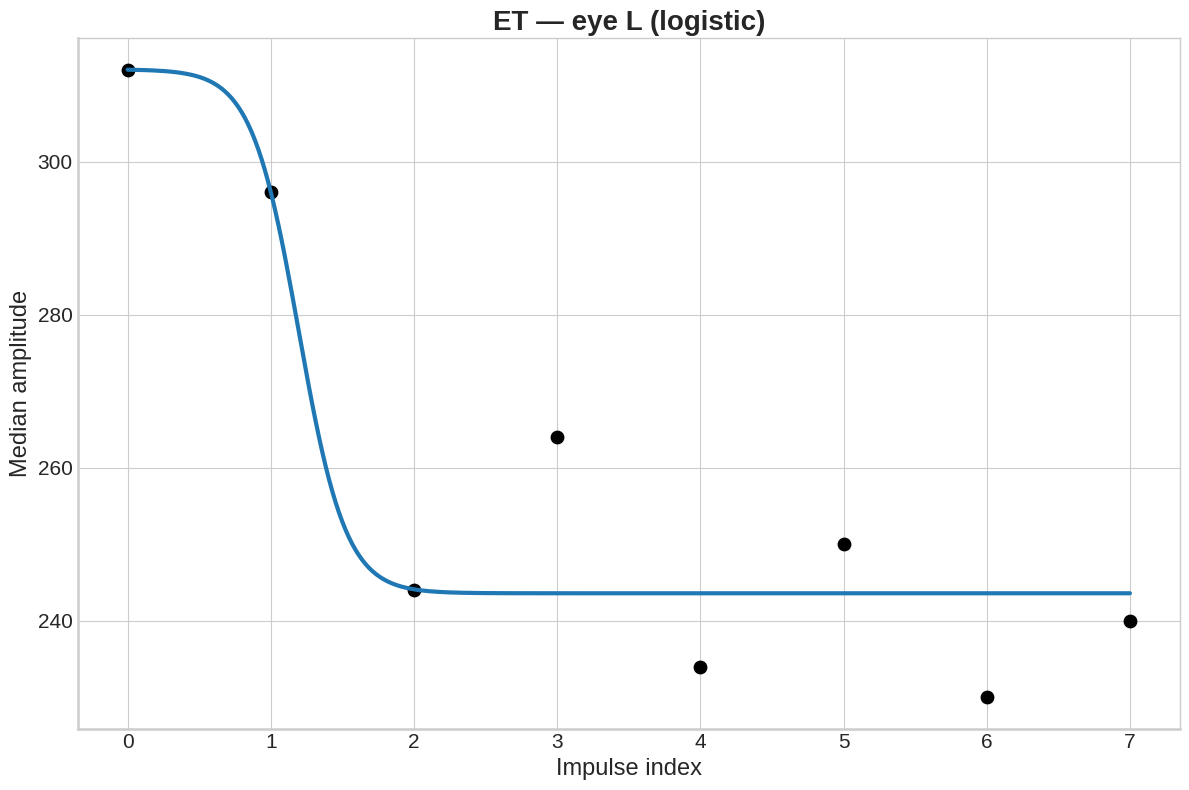

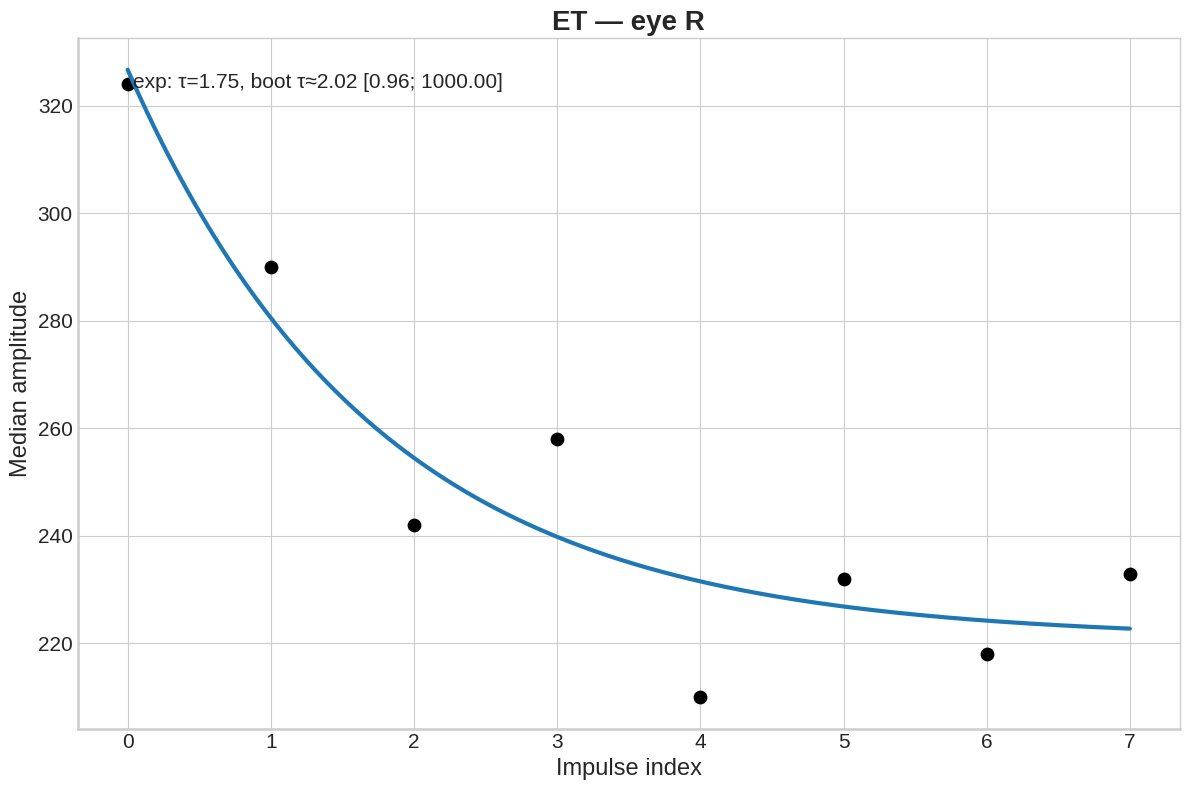

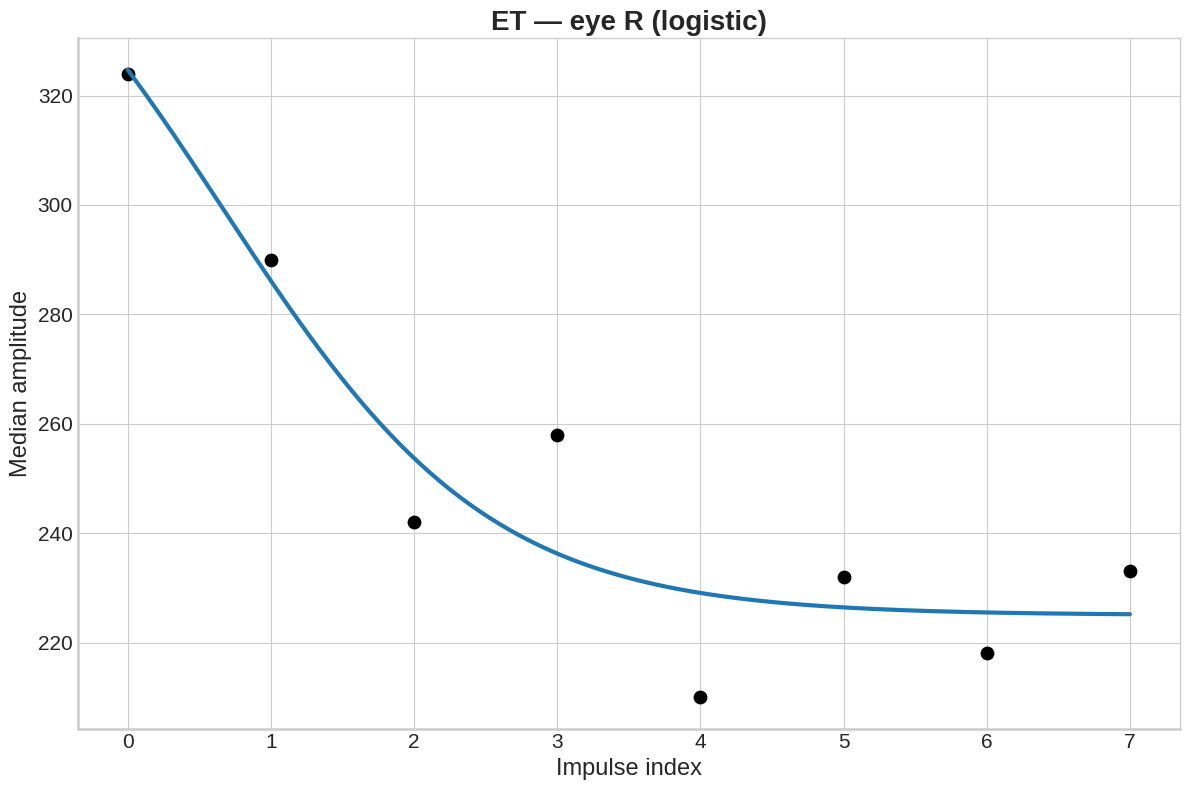

In [ ]:

summary_rows = []
group_map = {0: 'PD', 1: 'ET'}
rng = np.random.default_rng(RANDOM_STATE)

for grp_val, grp_name in group_map.items():
    mask_g = (y == grp_val)
    df_g = df.loc[mask_g].reset_index(drop=True)

    for eye in ['L', 'R']:
        if len(imps[eye]) < 3:
            continue

        x, M = group_eye_matrix(df, mask_g, eye)
        y_med = np.nanmedian(M, axis=0)

        exp_params, exp_fun = robust_curve_fit(x, y_med, kind='exp')
        if exp_params is not None:
            a_hat, b_hat, tau_hat = exp_params
            tau_boot, (tau_lo, tau_hi) = bootstrap_tau(df_g, eye, n_boot=N_BOOT, rng=rng)
            summary_rows.append(dict(
                group=grp_name, eye=eye, model='exp',
                a=a_hat, b=b_hat, tau=tau_hat,
                tau_boot=tau_boot, tau_ci_lo=tau_lo, tau_ci_hi=tau_hi,
                n_subjects=df_g.shape[0], n_impulses=len(x)
            ))
            ann = f"exp: τ={tau_hat:.2f}, boot τ≈{tau_boot:.2f} [{tau_lo:.2f}; {tau_hi:.2f}]"
        else:
            ann = "exp: fit failed"
            summary_rows.append(dict(
                group=grp_name, eye=eye, model='exp',
                a=np.nan, b=np.nan, tau=np.nan,
                tau_boot=np.nan, tau_ci_lo=np.nan, tau_ci_hi=np.nan,
                n_subjects=df_g.shape[0], n_impulses=len(x)
            ))
        plot_fit(x, y_med, exp_fun, title=f"{grp_name} — eye {eye}", annotate=ann,
                 out_path=f"fit_exp_{grp_name}_{eye}.png")

        log_params, log_fun = robust_curve_fit(x, y_med, kind='logistic')
        if log_params is not None:
            L_hat, U_hat, x0_hat, s_hat = log_params
            summary_rows.append(dict(
                group=grp_name, eye=eye, model='logistic',
                L=L_hat, U=U_hat, x0=x0_hat, s=s_hat,
                n_subjects=df_g.shape[0], n_impulses=len(x)
            ))
            ann2 = ""#f"logistic: x0={x0_hat:.2f}, s={s_hat:.2f}"
        else:
            ann2 = "logistic: fit failed"
            summary_rows.append(dict(
                group=grp_name, eye=eye, model='logistic',
                L=np.nan, U=np.nan, x0=np.nan, s=np.nan,
                n_subjects=df_g.shape[0], n_impulses=len(x)
            ))

        plot_fit(x, y_med, log_fun, title=f"{grp_name} — eye {eye} (logistic)",
                 annotate=ann2, out_path=f"fit_logistic_{grp_name}_{eye}.png") #out_path=f"fit_logistic_{grp_name}_{eye}.png")



In [ ]:
summary = pd.DataFrame(summary_rows)
summary.to_csv('latency_adaptation_fits_summary.csv', index=False)
print("Сводка параметров сохранена в: latency_adaptation_fits_summary.csv")
print(summary.round(3).to_string(index=False))

Сводка параметров сохранена в: latency_adaptation_fits_summary.csv
group eye    model       a       b   tau  tau_boot  tau_ci_lo  tau_ci_hi  n_subjects  n_impulses       L       U    x0     s
   PD   L      exp 201.114 127.663 2.699     2.852      0.926     16.914          17           8     NaN     NaN   NaN   NaN
   PD   L logistic     NaN     NaN   NaN       NaN        NaN        NaN          17           8 211.577 319.848 2.323 0.758
   PD   R      exp 192.273 121.524 4.027     3.523      0.926   1000.000          17           8     NaN     NaN   NaN   NaN
   PD   R logistic     NaN     NaN   NaN       NaN        NaN        NaN          17           8 219.653 302.617 2.605 0.562
   ET   L      exp 234.003  81.290 1.932     1.632      0.005   1000.000          10           8     NaN     NaN   NaN   NaN
   ET   L logistic     NaN     NaN   NaN       NaN        NaN        NaN          10           8 243.581 312.050 1.195 0.165
   ET   R      exp 220.834 105.879 1.746     2.022      0.